In [187]:
import pickle

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sklearn.cluster as cls
import sklearn.metrics as met
import sklearn.neighbors as nb

In [188]:
## Load road graph
road_graph: nx.DiGraph
with open("road_graph_nsl_sc.pickle", mode="rb") as file:
    road_graph = pickle.load(file)

## Load camera info
cameras_dict: dict
with open("cameras_info.pickle", mode="rb") as file:
    cameras_dict = pickle.load(file)

Silhouette Score: 0.42252725993730805
Region weights:  [2611488, 2281862]


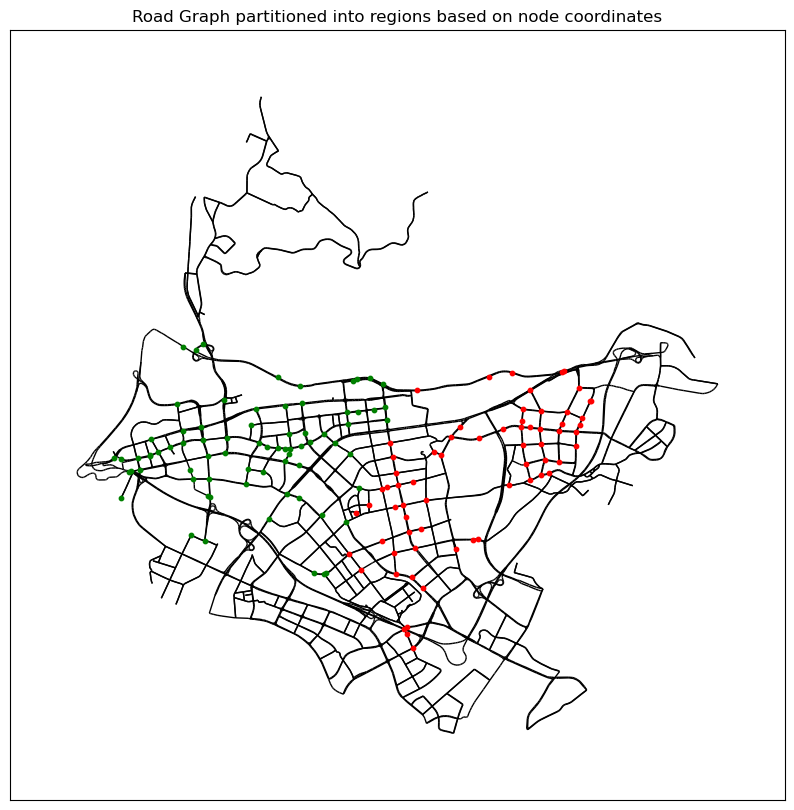

In [189]:
## Cluster nodes into regions
nodes = [{"node_id": node[0], "x": node[1]["pos"][0], "y": node[1]["pos"][1]} for node in road_graph.nodes(data=True)]
node_coordinates = np.array([[node["x"], node["y"]] for node in nodes])

seed = 0
number_of_regions = 2
k_means = cls.KMeans(number_of_regions, random_state=seed)
regions = k_means.fit_predict(node_coordinates)
print(f"Silhouette Score: {met.silhouette_score(node_coordinates, regions, random_state=seed)}")


def get_number_of_records_for_node(node_id):
    number_of_records = 0
    for camera in cameras_dict.values():
        if node_id == camera["node_id"]:
            number_of_records += camera["records"]
    return number_of_records


weights = np.array([get_number_of_records_for_node(node["node_id"]) for node in nodes])
region_weights = [0 for _ in set(regions)]
for region, weight in zip(regions, weights):
    region_weights[region] += weight
print("Region weights: ", region_weights)

## Visualize regions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
pos = nx.get_node_attributes(road_graph, "pos")

camera_node_ids = {camera["node_id"] for camera in cameras_dict.values()}

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    ax=ax
)

node_sets = [set() for _ in range(number_of_regions)]
for index, node in zip(regions, nodes):
    node_sets[index].add(node["node_id"])

colors = ["red", "green", "blue", "yellow"]
for color, node_set in zip(colors, node_sets):
    nx.draw_networkx_nodes(
        road_graph,
        pos,
        node_color=color,
        node_size=10,
        nodelist=node_set.intersection(camera_node_ids),
        ax=ax
    )
ax.set_title("Road Graph partitioned into regions based on node coordinates")

plt.show()

Silhouette Score: 0.38770842877338196
Region weights:  [2995888, 1897462]


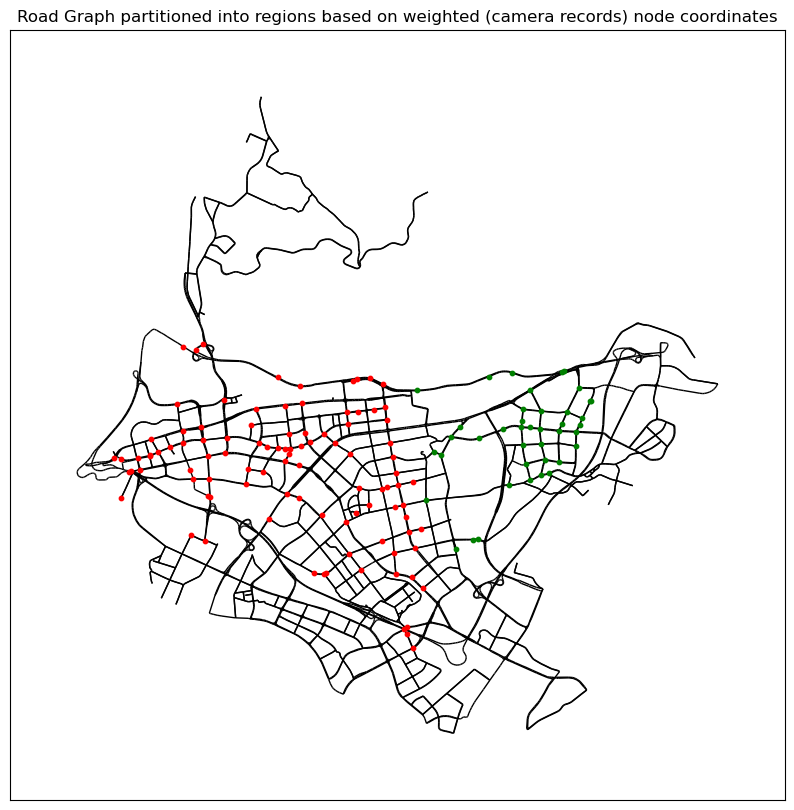

In [190]:
## Cluster nodes into regions based on camera records
k_means_weighted = cls.KMeans(number_of_regions, random_state=seed)
regions = k_means_weighted.fit_predict(node_coordinates, sample_weight=weights)
print(f"Silhouette Score: {met.silhouette_score(node_coordinates, regions, random_state=seed)}")

region_weights = [0 for _ in set(regions)]
for region, weight in zip(regions, weights):
    region_weights[region] += weight
print("Region weights: ", region_weights)

# Visualize regions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    ax=ax
)

node_sets = [set() for _ in range(number_of_regions)]
for index, node in zip(regions, nodes):
    node_sets[index].add(node["node_id"])

for color, node_set in zip(colors, node_sets):
    nx.draw_networkx_nodes(
        road_graph,
        pos,
        node_color=color,
        node_size=10,
        nodelist=node_set.intersection(camera_node_ids),
        ax=ax
    )
ax.set_title("Road Graph partitioned into regions based on weighted (camera records) node coordinates")

plt.show()

Silhouette Score: 0.46957775477801716
Region weights:  [2065098, 2828252]


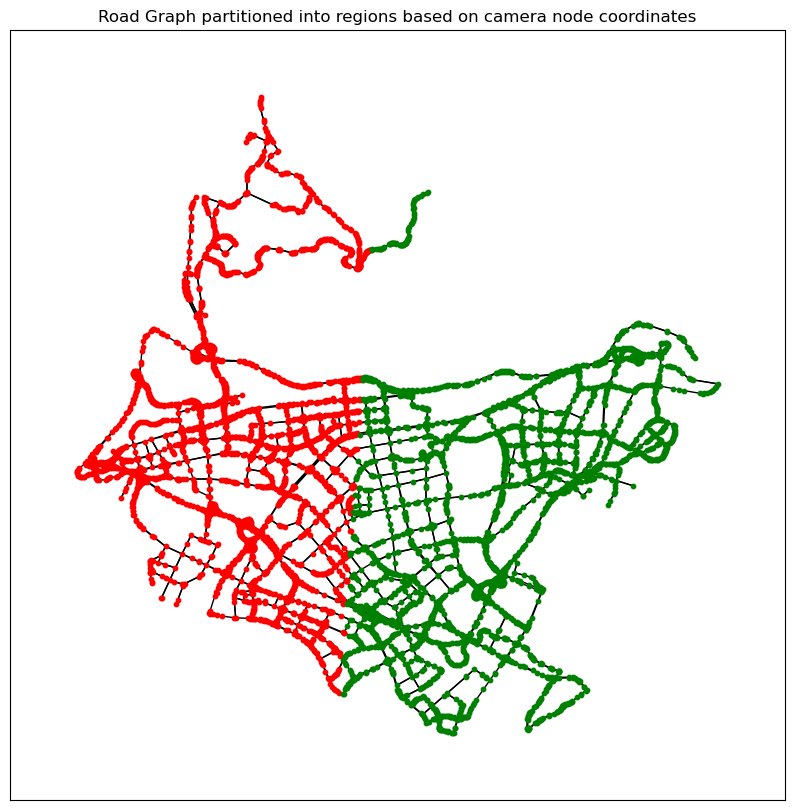

In [191]:
camera_nodes = [{"node_id": node[0], "x": node[1]["pos"][0], "y": node[1]["pos"][1]} for node in
                   road_graph.nodes(data=True) if node[0] in camera_node_ids]
camera_node_coordinates = np.array([[camera_node["x"], camera_node["y"]] for camera_node in camera_nodes])

k_means_cameras = cls.KMeans(number_of_regions, random_state=seed)
regions = k_means_cameras.fit_predict(camera_node_coordinates)
print(f"Silhouette Score: {met.silhouette_score(camera_node_coordinates, regions, random_state=seed)}")

region_weights = [0 for _ in set(regions)]
for region, camera_node in zip(regions, camera_nodes):
    weight = get_number_of_records_for_node(camera_node["node_id"])
    region_weights[region] += weight
print("Region weights: ", region_weights)

kd_tree = nb.KDTree(k_means_cameras.cluster_centers_)
indices = kd_tree.query(node_coordinates, k=1, return_distance=False)

node_sets = [set() for _ in range(indices.max() + 1)]
for node, index in zip(nodes, indices):
    index = index[0]
    node_sets[index].add(node["node_id"])

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    ax=ax
)

for index, node_set in enumerate(node_sets):
    nx.draw_networkx_nodes(
        road_graph,
        pos,
        node_color=colors[index],
        node_size=10,
        nodelist=node_set,
        ax=ax
    )
ax.set_title("Road Graph partitioned into regions based on camera node coordinates")

plt.show()